构建一个系统，按优先级对客户支持工单进行排序，并将工单转给相应的部门

有3个输入：

*   工单标题(文本输入)
*   工单的文本正文(文本输入)
*   用户添加的标签(分类输入，假定为one-hot编码）

有2个输出：

*   工单的优先级分数，它是介于0和1之间的标量(sigmoid输出)
*   应处理工单的部门(对所有部门做softmax)



In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers

In [3]:
vocabulary_size = 10000 # 标题或正文字数
num_tags = 100
num_departments = 4

构建模型

In [4]:
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

In [5]:
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

In [6]:
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

In [7]:
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

数据准备

In [8]:
num_samples = 1280

# 生成模拟数据
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

In [9]:
# 生成模拟标签
priority_labels = np.random.random(size=(num_samples, 1))
department_labels = np.random.randint(0, 2, size=(num_samples, num_departments))

编译模型

In [10]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

训练模型

In [11]:
model.fit([title_data, text_body_data, tags_data],
          [priority_labels, department_labels],
          epochs=1)

40/40 [==============================] - 2s 19ms/step - loss: 51.3716 - priority_loss: 0.3323 - department_loss: 51.0392 - priority_mean_absolute_error: 0.4982 - department_accuracy: 0.3430


评估

In [12]:
model.evaluate([title_data, text_body_data, tags_data],
               [priority_labels, department_labels])

40/40 [==============================] - 1s 12ms/step - loss: 54.4618 - priority_loss: 0.3353 - department_loss: 54.1264 - priority_mean_absolute_error: 0.5012 - department_accuracy: 0.1219


[54.461769104003906,
 0.33534371852874756,
 54.126441955566406,
 0.5012477040290833,
 0.12187500298023224]

预测

In [13]:
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 1s 10ms/step


或者使用字典（不依赖输入顺序）



```
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_labels, "department": department_labels},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_labels, "department": department_labels})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})
```



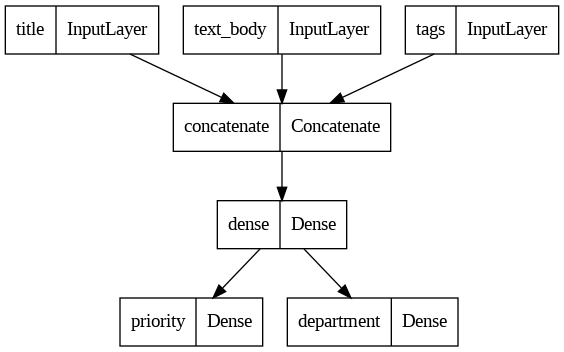

In [14]:
keras.utils.plot_model(model, "ticket_classifier.png")

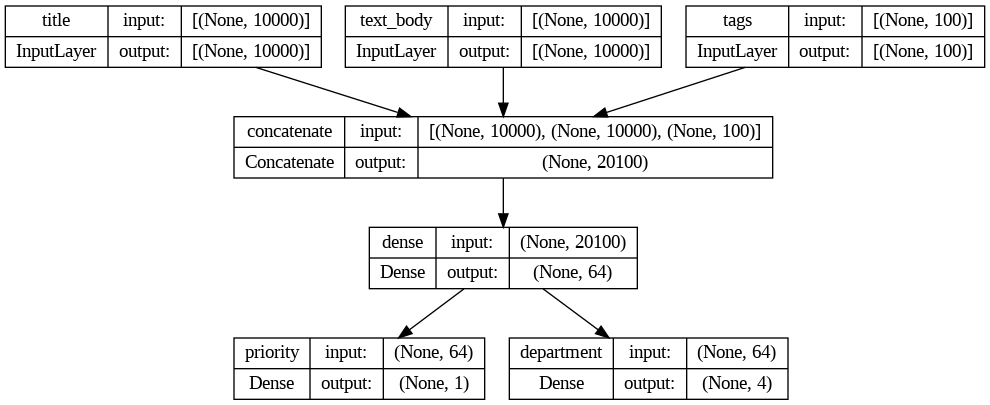

In [15]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title (InputLayer)          [(None, 10000)]              0         []                            
                                                                                                  
 text_body (InputLayer)      [(None, 10000)]              0         []                            
                                                                                                  
 tags (InputLayer)           [(None, 100)]                0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 20100)                0         ['title[0][0]',               
                                                                     'text_body[0][0]',       

In [17]:
model.layers

In [18]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [19]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

添加需求：估算某个问题工单的解决时长

这是一个分类问题：快速、简单、困难

可以复用之前的中间dense层

In [20]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

In [21]:
new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

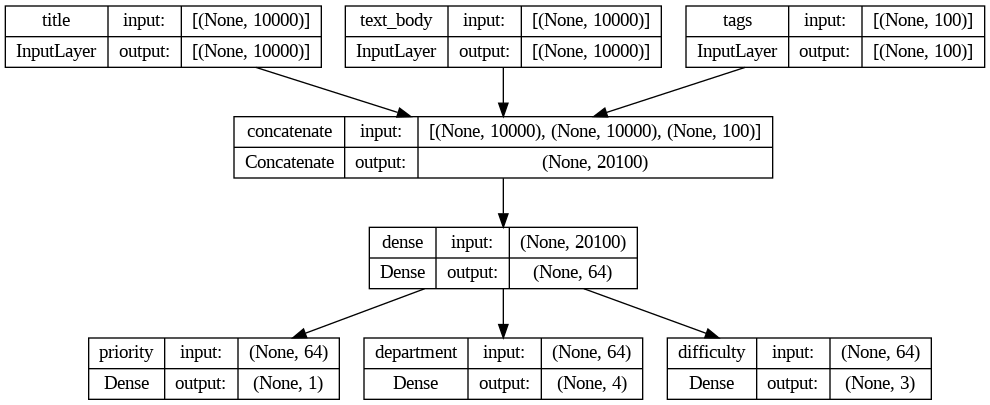

In [22]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)